# Recursive multi-step forecasting

Recursive multi-step forecasting involves using the predicted values from previous time steps as input to forecast the values for the subsequent time steps. The model initially predicts one time step ahead and then uses that forecast as an input for the next time step, continuing this recursive process until the desired forecast horizon is reached.

To clarify, since the value of $t_{n-1}$ is required to predict $t_{n}$, and $t_{n-1}$ is unknown, a recursive process is applied in which, each new prediction is based on the previous one.

<p style="text-align: center">
    <img src="../img/diagram-recursive-mutistep-forecasting.png" style="width: 500px">
    <br>
    <font size="2.5"> <i>Diagram of recursive multi-step forecasting</i></font>
    </p>
<p style="text-align: center">
    <img src="../img/recursive_forecasting_gif.gif" style="width: 500px; padding: 10px; background-color: white; border-radius: 4px;">
    <br>
    <font size="2.5"> <i>Recursive forecasting</i></font>
</p>

When using machine learning models for recursive multi-step forecasting, one of the major challenges is transforming the time series data into a matrix format that relates each value of the series to the preceding time window (lags). This process can be complex and time-consuming, requiring careful feature engineering to ensure the model can accurately capture the underlying patterns in the data.

<p style="text-align: center">
<img src="../img/matrix_transformation_with_exog_variable.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Time series transformation including an exogenous variable</i></font>
</p>

By using the classes <code>ForecasterRecursive</code>, it is possible to build machine learning models for recursive multi-step forecasting with ease. These classes can automatically transform the time series data into a matrix format suitable for input to a machine learning algorithm, and provide a range of options for tuning the model parameters to achieve the best possible performance.

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.plot import plot_prediction_intervals, set_dark_theme

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


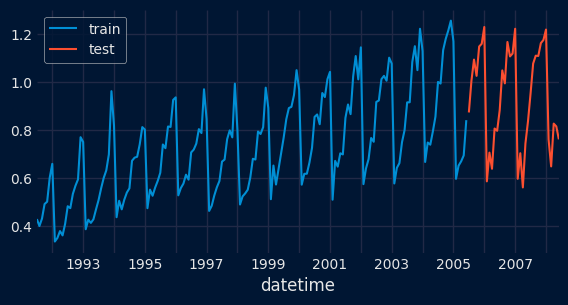

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Create and train forecaster

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 15,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=10),
                 transformer_y   = None, 
             )

forecaster.fit(y=data_train, store_in_sample_residuals=True)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-07 09:48:17 
Last fit date: 2025-03-07 09:48:17 
Skforecast version: 0.15.0 
Python version: 3.12.9 
Forecaster id: None

## Prediction

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    1.026507
2005-08-01    1.042429
2005-09-01    1.116730
Freq: MS, Name: pred, dtype: float64

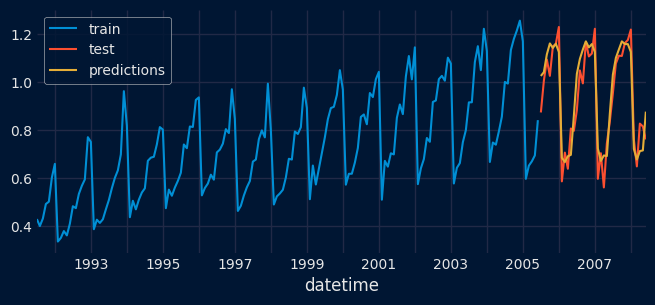

In [5]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006632513357651682


## Prediction intervals

A prediction interval defines the interval within which the true value of `y` is expected to be found with a given probability. For example, the prediction interval (5, 95) can be expected to contain the true prediction value with 90% probability. Skforecast implemets several methods to estimate prediction intervals, for a detailed explanation of the different methods visit [Probabilistic forecasting](../user_guides/probabilistic-forecasting-overview.html).

In [7]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    method   = 'bootstrapping',
                    n_boot   = 100
             )
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,1.026507,0.992734,1.104815
2005-08-01,1.042429,1.021760,1.120737
2005-09-01,1.116730,1.061465,1.196657


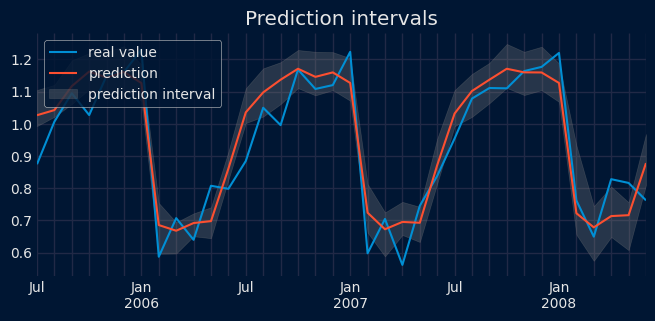

In [8]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = 'y',
    title               = "Prediction intervals",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)
ax.legend(loc='upper left');

## Feature importances

In [9]:
forecaster.get_feature_importances()

,feature,importance
11,lag_12,88
10,lag_11,47
1,lag_2,45
0,lag_1,35
12,lag_13,35
15,roll_mean_10,30
8,lag_9,29
6,lag_7,28
5,lag_6,26
13,lag_14,24


## Training and prediction matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process. Check the [How to Extract Training and Prediction Matrices](../user_guides/training-and-prediction-matrices.html) user guide for more information.

## Differentiation

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series differentiation, visit our example: <a href="https://www.cienciadedatos.net/documentos/py49-modelling-time-series-trend-with-tree-based-models.html">Modelling time series trend with tree based models</a>.

</div>

In [10]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 15,
                 differentiation = 1
             )

forecaster.fit(y=data_train)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: None 
Window size: 16 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-03-07 09:48:22 
Last fit date: 2025-03-07 09:48:22 
Skforecast version: 0.15.0 
Python version: 3.12.9 
Forecaster id: None

In [11]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.909529
2005-08-01    0.941633
2005-09-01    1.007650
Freq: MS, Name: pred, dtype: float64